<a href="https://colab.research.google.com/github/yoonhero/Brainstormers/blob/master/paperwithcode/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set Data path
datapath = './data'
os.makedirs(datapath, exist_ok=True)

# Pre-process
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Laod MNIST
train_dataset = datasets.MNIST(datapath, train=True, download=True, transform=trans)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
img, label = train_dataset.data, train_dataset.targets

img.shape, label.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

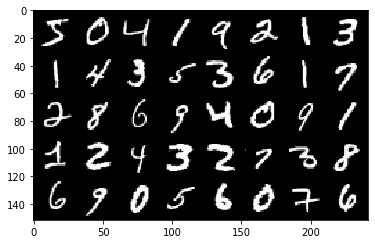

In [5]:
img = img.unsqueeze(1)

img_grid = utils.make_grid(img[:40], ncol=8, padding=2)
def show(img):
    img = img.numpy() # Tensor -> numpy array
    img = img.transpose([1,2,0]) # C x H x W -> H x W x C
    plt.imshow(img, interpolation='nearest')
show(img_grid)

In [6]:
batch_size = 64
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# set parameters
params = {
    'num_classes':10,
    'noise_z':100,
    'input_size':(1,28,28)
}

In [8]:
#### GENERATOR ####
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.num_classes = params.get("num_classes")
        self.noise_z = params.get("noise_z")
        self.input_size = params.get("input_size")

        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

        self.gen = nn.Sequential(
            nn.Linear(self.num_classes+self.noise_z, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(self.input_size))),
            nn.Tanh()
        )


    def forward(self, z, labels):
        # noise 와 label을 합치기
        gen_input = torch.cat((self.label_emb(labels), z), axis=-1)

        x = self.gen(gen_input)
        x = x.view(-1,*self.input_size )
        return x

x = torch.randn(16, 100, device=device)
label = torch.randint(0, 10, (16, ), device=device)
model_gen = Generator(params).to(device)
out_gen = model_gen(x, label)
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


In [9]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.input_size = params.get("input_size")
        self.num_classes = params.get("num_classes")
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)

        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 512),

            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        dis_input = torch.cat((img.view(-1, 28*28), self.label_embedding(labels)), -1)

        x = self.dis(dis_input)

        return x

x = torch.randn(16,1,28,28,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)



torch.Size([16, 1])


In [10]:
# Initial Weight
def initialize_weights(model):
    classname = model.__class__.__name__

    if classname.find("Linear") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (dis): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [11]:
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1 = 0.5
beta2 = 0.999


opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))

nz = params.get("noise_z")
num_epochs = 100

loss_history = {"gen":[], "dis":[]}

In [12]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_data_loader:
        batch_size = xb.shape[0]

        xb, yb = xb.to(device), yb.to(device)

        yb_real = torch.ones((batch_size, 1), device=device)
        yb_fake = torch.zeros((batch_size, 1), device=device)

        model_gen.zero_grad()
        noise = torch.randn(batch_size, 100).to(device)
        gen_label = torch.randint(0, 10, (batch_size, )).to(device)

        out_gen = model_gen(noise, gen_label)

        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()

        opt_gen.step()


        opt_dis.zero_grad()

        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        out_dis = model_dis(out_gen.detach(), gen_label)
        loss_fake = loss_func(out_dis, yb_fake)

        loss_dis = (loss_real+loss_fake) / 2

        loss_dis.backward()
        opt_dis.step()

        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))
        

Epoch: 1, G_Loss: 0.342187, D_Loss: 0.781723, time: 0.33 min
Epoch: 2, G_Loss: 1.184231, D_Loss: 0.380431, time: 0.67 min
Epoch: 3, G_Loss: 0.954613, D_Loss: 0.585345, time: 1.00 min
Epoch: 4, G_Loss: 1.615769, D_Loss: 0.440364, time: 1.34 min
Epoch: 5, G_Loss: 1.957145, D_Loss: 0.474668, time: 1.67 min
Epoch: 6, G_Loss: 1.494287, D_Loss: 0.302080, time: 2.00 min
Epoch: 7, G_Loss: 2.117360, D_Loss: 0.384505, time: 2.34 min
Epoch: 8, G_Loss: 1.231537, D_Loss: 0.495049, time: 2.67 min
Epoch: 9, G_Loss: 1.234041, D_Loss: 0.360533, time: 3.00 min
Epoch: 10, G_Loss: 1.208939, D_Loss: 0.300197, time: 3.34 min
Epoch: 11, G_Loss: 1.287525, D_Loss: 0.389971, time: 3.67 min
Epoch: 12, G_Loss: 2.429752, D_Loss: 0.304824, time: 4.00 min
Epoch: 13, G_Loss: 2.330787, D_Loss: 0.312562, time: 4.34 min
Epoch: 14, G_Loss: 2.015189, D_Loss: 0.199389, time: 4.67 min
Epoch: 15, G_Loss: 1.931990, D_Loss: 0.444634, time: 5.00 min
Epoch: 17, G_Loss: 2.026120, D_Loss: 0.283462, time: 5.34 min
Epoch: 18, G_Loss

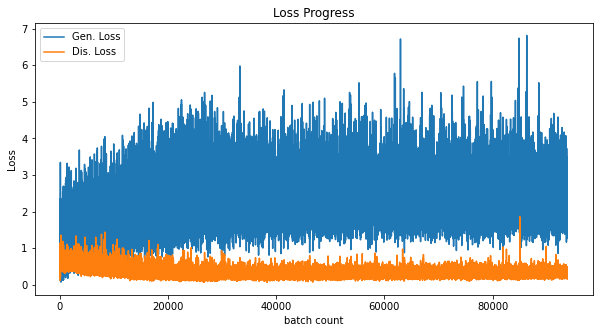

In [13]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

tensor([3, 6, 2, 2, 2, 2, 1, 3, 9, 7, 2, 3, 3, 0, 1, 7], device='cuda:0')
tensor([6, 3, 8, 0, 1, 9, 0, 0, 9, 5, 1, 3, 7, 3, 3, 1], device='cuda:0')
tensor([6, 5, 2, 8, 2, 4, 3, 7, 9, 8, 5, 9, 6, 8, 8, 4], device='cuda:0')
tensor([0, 2, 5, 8, 1, 5, 5, 0, 2, 1, 5, 4, 2, 9, 3, 3], device='cuda:0')
tensor([5, 8, 7, 0, 6, 6, 6, 0, 6, 0, 9, 8, 8, 6, 8, 7], device='cuda:0')
tensor([5, 4, 3, 9, 3, 2, 1, 0, 6, 4, 0, 0, 1, 5, 5, 7], device='cuda:0')
tensor([7, 1, 7, 8, 5, 9, 1, 4, 6, 7, 0, 2, 6, 8, 8, 8], device='cuda:0')
tensor([2, 9, 5, 0, 1, 5, 5, 2, 5, 2, 7, 8, 9, 4, 2, 4], device='cuda:0')
tensor([0, 6, 7, 9, 0, 9, 2, 2, 7, 7, 3, 7, 9, 7, 0, 7], device='cuda:0')
tensor([1, 5, 1, 8, 9, 5, 8, 4, 3, 7, 8, 1, 9, 2, 1, 2], device='cuda:0')
tensor([6, 9, 6, 2, 1, 8, 5, 9, 4, 5, 8, 8, 2, 8, 6, 4], device='cuda:0')
tensor([0, 9, 6, 2, 3, 5, 3, 4, 7, 9, 6, 5, 2, 2, 9, 7], device='cuda:0')
tensor([5, 8, 5, 5, 4, 3, 4, 6, 9, 6, 5, 9, 1, 2, 6, 0], device='cuda:0')
tensor([5, 9, 1, 4, 9, 0, 2, 4, 0, 8, 

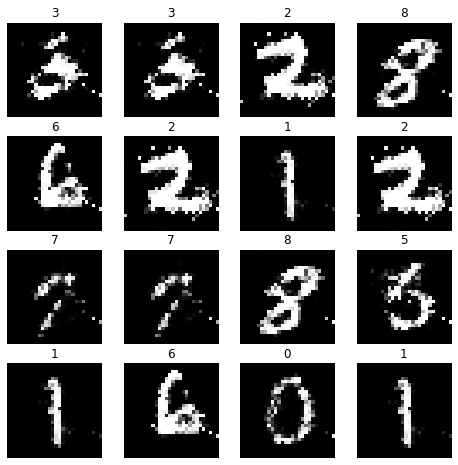

In [15]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fig = plt.figure(figsize=(8,8))
    cols, rows = 4, 4 # row와 col 갯수
    for i in range(rows * cols):
        fixed_noise = torch.randn(16, 100, device=device)
        label = torch.randint(0,10,(16,), device=device)
        print(label)
        img_fake = model_gen(fixed_noise, label).detach().cpu()
        fig.add_subplot(rows, cols, i+1)
        plt.title(label[i].item())
        plt.axis('off')
        plt.imshow(img_fake[i].squeeze(), cmap='gray')
plt.show()